# Laboratoire 4 : Développement d'un système intelligent
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Alexandre Bleau — BLEA14058906 / David Létinaud  — LETD05129708 / Thomas Lioret   — LIOT20069605|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2019                                            |
| Groupe                | 1                                                       |
| Numéro du laboratoire | 4                                                       |
| Professeur            | Prof. LOMBAERT                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 18/12/2019                                              |

In [ ]:
import numpy as np

## Introduction et revue de la littérature





Pour choisir correctement les modèles à associés aux ensembles de features, il est important d'étudier ce qui a déjà été fait.
Ainsi, on s'est notamment appuyé sur l'étude "FACILITATING COMPREHENSIVE BENCHMARKING EXPERIMENTS
ON THE MILLION SONG DATASET" réalisée par l'ISMIR (International Society for Music Information Retrieval) en 2012.

La combinaison la plus performante a permis d'obtenir une précision de 27,41 % en appliquant un modèle SVM sur l'ensemble de features "Statistical Spectrum Descriptor"(SSD). Sur ces caractéristiques, l'algorithme KNN a produit une précision comparable de 27,07 %. Les autres modèles testés, baïes naïf, l'arbre de décision et "random forest" ont tous donné un taux d'exactitude entre 14 et 20 % environ. Outre le SSD, d'autres ensembles ont également fait l'objet d'essais, mais tous ont donné des résultats d'une précision inférieur, à une près. 
Les ensembles "MFCC" et "Spectral Derivates" offrent tout de même des performances comparables bien qu'inférieures à celle que peut offrir SSD.

Toutefois, cette étude n'analyse pas les performances que peut offrir un réseau de neurones. En effet, ce modèle de classification n'était pas encore très développé. On a tout de même trouvé une étude plus récente sur la classification de genre de musique. Celle-ci utilise une autre base de donnée appelée : "Free Music Archive" (FMA) constitué de 161 genres. Cette étude, "FMA: A DATASET FOR MUSIC ANALYS" est disponible ici : harxiv.org/pdf/1612.01840.pdf. Bien que le dataset soit différent, il est intéressant de noter que le modèle MLP ("MultiLayer Perceptron") performe très bien avec l'ensemble de features MFCC. Il atteint même une précision de 53%, ce qui en fait pottentiellement un très bon candidat pour notre dataset.

Ainsi, par la suite, nous étudierons 3 modèles qui semblent être les plus performants : MLP (MultiLayer Perceptron), SVM (Support Vector Machine) et RF (Random Forest). Notons que nous préferons pas utilisé KNN puisque celui-ci est très long à entrainer pour des problème de grandes dimensions.

## Exploration des datasets

En premier, il peut être intéressant d'analyser les datasets disponibles. Cela nous permettra par la suite de faire des choix plus éclairés et pourra mieux expliquer les résultats obtenus.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
dataset_path_tab = []
dataset_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

On peut d'abord étudier le balancement de chacune des classes des datasets.

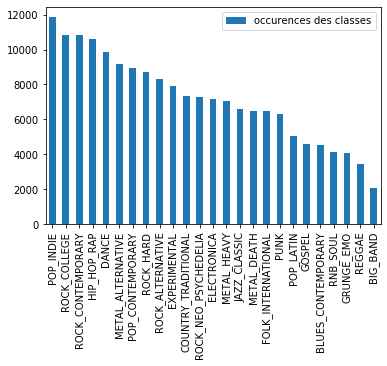

In [60]:
features_list = pd.read_csv(dataset_path_tab[0], header=None, sep = ',')
Y = features_list.iloc[:,-1]
df = pd.DataFrame(Y.value_counts())
ax = df.plot(kind='bar')
ax.legend(["occurences des classes"]);

Cette analyse nous montre que la plupart des classes apparaissent environ 7000 fois. Le dataset n'est toutefois pas balancé puisque le nombre d'occurence des classe peu varier entre 2000 et 12000. C'est une caractéristique du dataset qu'il faudra prendre en compte par la suite.

[168, 26, 16, 96, 20, 10, 124, 420, 60, 420]


Text(0.5, 1.0, 'Number of features per dataset')

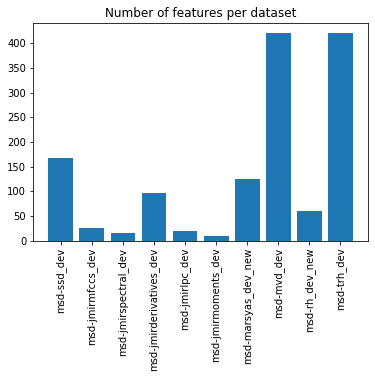

In [62]:
nb_features = []
dataset_path_label = []
for dataset_path in dataset_path_tab:
    features_list = pd.read_csv(dataset_path, header=None, sep = ',', nrows=1)
    nb_features.append(len(features_list.iloc[0,2:-1]))
    dataset_path_label.append(dataset_path.split('/')[2])
    
print(nb_features)
plt.bar(dataset_path_label,nb_features )
plt.xticks(dataset_path_label, rotation='vertical')
plt.title("Number of features per dataset")

Ainsi, on peut remarquer que le nombre de features varie beaucoup en fonction du dataset utilisé. Le nombre de features est particulièrement élevé avec les datasets MVD et TRH. Ces informations sont très utiles pour déterminer s'il est nécessaire de réduire ce nombre avec un algorithme d'analyse en composantes principales (PCA) par exemple.

## Question 2

Comme expliqué précedemment, le modèle MLP est un bon candidat. Toutefois, nous n'avons pas de données sur sa performance avec les ensembles de features du dataset MSD. Nous allons donc créé un modèle MLP est le tester sur tout les ensembles de features disponible pour comparer ses performances. Nous irons plus en détails dans l'ajustement des hyperparamètres par la suite.  
### Validation
Nous utiliserons ici une méthode validation hold-out avec 80% du dataset comme données d'entrainement et 20% en tant que données de tests. Nous utilisons cette méthode de validation pour le choix du partitionnement puisqu'elle à l'avantage d'être plus rapide que la validation croisée.
### Prétraitement
Par ailleurs, on utilise l'option "stratify" de la fonction train_test_split pour que les proportions de chacune des classes soit égale dans le dataset d'entrainement et de celui de test.
On normalise aussi indépendemment chaque features par rapport à la valeur maximale dans le dataset.

#### CLASS_WEIGHTS????

### Configuration de l'environnement
Ici le programme à été exécuté sur une machine ayant les caractéristiques suivantes :

### Partitionnement des données
Pour déterminer au mieux le partitionnement des données, nous testons les performances de chaque modèle choisi avec chaque ensemble de features. Nous irons plus en détails dans l'ajustement des hyperparamètres des modèles par la suite.

In [7]:
from RN_model import RN_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import shutil
import time
import numpy as np
from functions import get_data, plot_perf_epochs,plot_perf_delay

In [2]:
dataset_path_tab = []
dataset_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

In [3]:
# MLP hyperparamaters
layer_sizes = [500]
epochs = 50
learning_rate = 0.0005
batch_size = 500

dropout = 0.5

In [5]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0
f1_RN = []
acc_RN = []

In [4]:
try:      
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
# Callbacks pour affichage des performances dans tensorboard : callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(len(dataset_path_tab)):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006

In [8]:
cpt = 0
for path_ in dataset_path_tab:
    # Get data / normalize it / split into train&test
    X, Y = get_data(path_)
    X = preprocessing.normalize(X, norm='max',axis = 0)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,random_state=60, stratify=Y)  # 80% training and 20% test

    # Calcul du nombres de features/classes et taille du dataset
    nb_features = len(X[0])
    nb_classes = max(Y)+1
    train_size = len(X)

    model = RN_model(layer_sizes, dropout, learning_rate, nb_features, nb_classes)
    
    #### Apprentissage                                                                                                                                                               
    start = time.time()                                                                                                                   
    hist_obj = model.fit(X_train[0:train_size], Y_train[0:train_size], batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]]) 
    end = time.time()
    training_delay_RN.append(end - start)
    
    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                  
    start = time.time()
    Y_pred_temp = model.predict(X_test)
    end = time.time()
    predicting_delay_RN.append(end - start)

    # Remise en forme de Y_pred
    Y_pred = []
    for i in Y_pred_temp:
        Y_pred.append(np.argmax(i)) 
    
    f1 = metrics.f1_score(Y_test, Y_pred,average='weighted')
    acc = metrics.accuracy_score(Y_test, Y_pred)
    print("acc :", acc,"f1 :", f1)
    
    f1_RN.append(f1)
    acc_RN.append(acc)
    cpt+=1

Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 7s 48us/sample - loss: 2.7883 - acc: 0.1633 - val_loss: 2.5980 - val_acc: 0.2090
Epoch 2/50
143644/143644 [==============================] - 8s 56us/sample - loss: 2.5832 - acc: 0.2113 - val_loss: 2.5262 - val_acc: 0.2287
Epoch 3/50
143644/143644 [==============================] - 6s 42us/sample - loss: 2.5257 - acc: 0.2293 - val_loss: 2.4779 - val_acc: 0.2426
Epoch 4/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.4905 - acc: 0.2412 - val_loss: 2.4471 - val_acc: 0.2539
Epoch 5/50
143644/143644 [==============================] - 6s 40us/sample - loss: 2.4659 - acc: 0.2471 - val_loss: 2.4293 - val_acc: 0.2612
Epoch 6/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.4441 - acc: 0.2544 - val_loss: 2.4148 - val_acc: 0.2643
Epoch 7/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.4286 - acc: 0.2593

Epoch 7/50
143644/143644 [==============================] - 4s 28us/sample - loss: 2.7055 - acc: 0.1813 - val_loss: 2.6797 - val_acc: 0.18880s - loss: 2.7062 - ac
Epoch 8/50
143644/143644 [==============================] - 4s 31us/sample - loss: 2.6921 - acc: 0.1852 - val_loss: 2.6645 - val_acc: 0.1943
Epoch 9/50
143644/143644 [==============================] - 5s 32us/sample - loss: 2.6799 - acc: 0.1883 - val_loss: 2.6539 - val_acc: 0.1966
Epoch 10/50
143644/143644 [==============================] - 4s 29us/sample - loss: 2.6699 - acc: 0.1923 - val_loss: 2.6455 - val_acc: 0.1998
Epoch 11/50
143644/143644 [==============================] - 4s 29us/sample - loss: 2.6606 - acc: 0.1954 - val_loss: 2.6362 - val_acc: 0.2012
Epoch 12/50
143644/143644 [==============================] - 5s 32us/sample - loss: 2.6529 - acc: 0.1971 - val_loss: 2.6278 - val_acc: 0.2036
Epoch 13/50
143644/143644 [==============================] - 4s 29us/sample - loss: 2.6455 - acc: 0.1995 - val_loss: 2.6237 - val

143644/143644 [==============================] - 4s 26us/sample - loss: 2.7303 - acc: 0.1721 - val_loss: 2.7178 - val_acc: 0.1775
Epoch 14/50
143644/143644 [==============================] - 5s 34us/sample - loss: 2.7258 - acc: 0.1733 - val_loss: 2.7139 - val_acc: 0.1788
Epoch 15/50
143644/143644 [==============================] - 4s 31us/sample - loss: 2.7219 - acc: 0.1754 - val_loss: 2.7089 - val_acc: 0.1793
Epoch 16/50
143644/143644 [==============================] - 4s 26us/sample - loss: 2.7169 - acc: 0.1753 - val_loss: 2.7043 - val_acc: 0.1803loss:
Epoch 17/50
143644/143644 [==============================] - 4s 27us/sample - loss: 2.7127 - acc: 0.1767 - val_loss: 2.7007 - val_acc: 0.1819
Epoch 18/50
143644/143644 [==============================] - 4s 30us/sample - loss: 2.7094 - acc: 0.1780 - val_loss: 2.6965 - val_acc: 0.1828
Epoch 19/50
143644/143644 [==============================] - 4s 26us/sample - loss: 2.7045 - acc: 0.1791 - val_loss: 2.6922 - val_acc: 0.1837
Epoch 20/50
1

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.20074628943777673 f1 : 0.16373846305366144
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 9s 60us/sample - loss: 2.9268 - acc: 0.1300 - val_loss: 2.7739 - val_acc: 0.1650
Epoch 2/50
143644/143644 [==============================] - 8s 58us/sample - loss: 2.7488 - acc: 0.1665 - val_loss: 2.6938 - val_acc: 0.1810s: 2.7514 
Epoch 3/50
143644/143644 [==============================] - 8s 55us/sample - loss: 2.6865 - acc: 0.1810 - val_loss: 2.6424 - val_acc: 0.1955
Epoch 4/50
143644/143644 [==============================] - 8s 56us/sample - loss: 2.6455 - acc: 0.1917 - val_loss: 2.6126 - val_acc: 0.2026
Epoch 5/50
143644/143644 [==============================] - 9s 62us/sample - loss: 2.6211 - acc: 0.1978 - val_loss: 2.6009 - val_acc: 0.2021
Epoch 6/50
143644/143644 [==============================] - 9s 60us/sample - loss: 2.6048 - acc: 0.2021 - val_loss: 2.5771 - val_acc: 0.2104
Epoch 7/50
143644/143644 [================

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.20322463869009497 f1 : 0.16613788766468798
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 6s 41us/sample - loss: 3.0572 - acc: 0.0958 - val_loss: 2.9393 - val_acc: 0.1317
Epoch 2/50
143644/143644 [==============================] - 5s 37us/sample - loss: 2.9148 - acc: 0.1337 - val_loss: 2.8805 - val_acc: 0.1432
Epoch 3/50
143644/143644 [==============================] - 5s 36us/sample - loss: 2.8789 - acc: 0.1419 - val_loss: 2.8614 - val_acc: 0.1465
Epoch 4/50
143644/143644 [==============================] - 5s 36us/sample - loss: 2.8641 - acc: 0.1449 - val_loss: 2.8487 - val_acc: 0.1479
Epoch 5/50
143644/143644 [==============================] - 5s 36us/sample - loss: 2.8523 - acc: 0.1473 - val_loss: 2.8393 - val_acc: 0.1494
Epoch 6/50
143644/143644 [==============================] - 5s 35us/sample - loss: 2.8427 - acc: 0.1490 - val_loss: 2.8302 - val_acc: 0.1518
Epoch 7/50
143644/143644 [==========================

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.1784689927877252 f1 : 0.13656309309069015
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 6s 41us/sample - loss: 3.1478 - acc: 0.0926 - val_loss: 2.9573 - val_acc: 0.1430
Epoch 2/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.8693 - acc: 0.1463 - val_loss: 2.7705 - val_acc: 0.1657
Epoch 3/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.7725 - acc: 0.1669 - val_loss: 2.7129 - val_acc: 0.1824
Epoch 4/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.7155 - acc: 0.1838 - val_loss: 2.6518 - val_acc: 0.2055
Epoch 5/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.6734 - acc: 0.1967 - val_loss: 2.6180 - val_acc: 0.2119
Epoch 6/50
143644/143644 [==============================] - 5s 33us/sample - loss: 2.6430 - acc: 0.2040 - val_loss: 2.6032 - val_acc: 0.2160
Epoch 7/50
143644/143644 [===========================

143644/143644 [==============================] - 6s 42us/sample - loss: 2.7183 - acc: 0.1856 - val_loss: 2.7079 - val_acc: 0.1901
Epoch 15/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7153 - acc: 0.1870 - val_loss: 2.7066 - val_acc: 0.1904
Epoch 16/50
143644/143644 [==============================] - 6s 44us/sample - loss: 2.7129 - acc: 0.1873 - val_loss: 2.7044 - val_acc: 0.1896
Epoch 17/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7106 - acc: 0.1881 - val_loss: 2.7017 - val_acc: 0.1918
Epoch 18/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7070 - acc: 0.1898 - val_loss: 2.6989 - val_acc: 0.1913
Epoch 19/50
143644/143644 [==============================] - 6s 43us/sample - loss: 2.7043 - acc: 0.1886 - val_loss: 2.6976 - val_acc: 0.1909
Epoch 20/50
143644/143644 [==============================] - 6s 41us/sample - loss: 2.7032 - acc: 0.1895 - val_loss: 2.6954 - val_acc: 0.1920
Epoch 21/50
143644

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.20024505026315056 f1 : 0.16465149509434052
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 14s 97us/sample - loss: 2.9545 - acc: 0.1341 - val_loss: 2.8105 - val_acc: 0.1681
Epoch 2/50
143644/143644 [==============================] - 13s 88us/sample - loss: 2.7932 - acc: 0.1700 - val_loss: 2.7469 - val_acc: 0.1779
Epoch 3/50
143644/143644 [==============================] - 12s 87us/sample - loss: 2.7365 - acc: 0.1811 - val_loss: 2.7058 - val_acc: 0.1900
Epoch 4/50
143644/143644 [==============================] - 13s 87us/sample - loss: 2.7025 - acc: 0.1891 - val_loss: 2.6827 - val_acc: 0.1944
Epoch 5/50
143644/143644 [==============================] - 12s 86us/sample - loss: 2.6804 - acc: 0.1946 - val_loss: 2.6691 - val_acc: 0.1980
Epoch 6/50
143644/143644 [==============================] - 12s 86us/sample - loss: 2.6631 - acc: 0.1986 - val_loss: 2.6555 - val_acc: 0.2020
Epoch 7/50
143644/143644 [====================

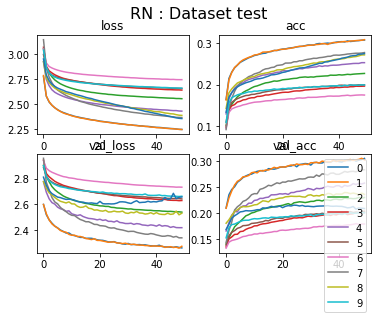

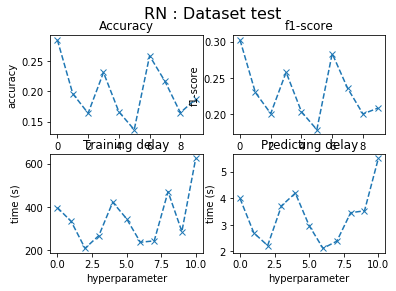

In [9]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)  

# Pour affichage
sub_title = ['loss','acc','val_loss','val_acc']
x_lab = "epochs"
leg = [str(i) for i in range(len(direct_path_tab))]  
titre = "RN : Dataset test"                                                                                                                                         

plot_perf_epochs(ho, leg, titre ,sub_title)
plot_perf_delay(f1_RN,acc_RN,training_delay_RN,predicting_delay_RN,titre)

On remarque que le réseau de neurones performe mieux pour les dataset 0, 3 et 6, c'est à dire avec les ensemble de features : SSD, derivates et maryas.

Pour faire un choix éclairé, on réalise des tests similaires pour les 2 autres modèles choisis.

## Question 3
### Description des modèles et justifications


#### Etudes des hyperparamètres? complète avec tous les tests????????????????????????

## Question 4

### Matrice des expérimentations

### QU'est ce que c'est????????????????????????????????????
Matrices des performances?? accuracy/F1-scores pk "matrice"


### matrices de confusion!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
=> pas lisibles du tout!!!!!!!!

### Matrice des résultats de l'étude des hyperparamètres
### QU'est ce que c'est????????????????????????????????????

### Graphiques

Comme pour le TP précédent, on peut étudier le modèle MLP selon les hyperparamètres suivant : 
  . Nombre de couches cachées
  . Nombre de perceptrons sur la couche cachée
  . Taux d'apprentissage
  . Nombre d'epochs

In [2]:
from RN_hyperparam import *

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
layer_size_test()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 1s 13ms/sample - loss: 3.2384 - acc: 0.0300 - val_loss: 3.2180 - val_acc: 0.0427
Epoch 2/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.2074 - acc: 0.0800 - val_loss: 3.2120 - val_acc: 0.0629
Epoch 3/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.1930 - acc: 0.0800 - val_loss: 3.2067 - val_acc: 0.0753
Epoch 4/5
100/100 [==============================] - 1s 7ms/sample - loss: 3.1621 - acc: 0.1300 - val_loss: 3.2023 - val_acc: 0.0774
Epoch 5/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.1830 - acc: 0.0600 - val_loss: 3.1986 - val_acc: 0.0800


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.07997549497368495 f1 : 0.01605180981511778
Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 2s 16ms/sample - loss: 3.1996 - acc: 0.0600 - val_loss: 3.2196 - val_acc: 0.0477
Epoch 2/5
100/100 [==============================] - 1s 8ms/sample - loss: 3.2183 - acc: 0.0700 - val_loss: 3.2171 - val_acc: 0.0539
Epoch 3/5
100/100 [==============================] - 1s 8ms/sample - loss: 3.1988 - acc: 0.0600 - val_loss: 3.2150 - val_acc: 0.0610
Epoch 4/5
100/100 [==============================] - 1s 8ms/sample - loss: 3.1967 - acc: 0.1000 - val_loss: 3.2129 - val_acc: 0.0636
Epoch 5/5
100/100 [==============================] - 1s 8ms/sample - loss: 3.2196 - acc: 0.0500 - val_loss: 3.2111 - val_acc: 0.0638


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.06382445490239759 f1 : 0.012349587016409157
Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 2s 19ms/sample - loss: 3.2338 - acc: 0.0500 - val_loss: 3.2212 - val_acc: 0.0500
Epoch 2/5
100/100 [==============================] - 1s 9ms/sample - loss: 3.2636 - acc: 0.0200 - val_loss: 3.2188 - val_acc: 0.0500
Epoch 3/5
100/100 [==============================] - 1s 9ms/sample - loss: 3.2382 - acc: 0.0500 - val_loss: 3.2168 - val_acc: 0.0500
Epoch 4/5
100/100 [==============================] - 1s 9ms/sample - loss: 3.1949 - acc: 0.0900 - val_loss: 3.2152 - val_acc: 0.0499
Epoch 5/5
100/100 [==============================] - 1s 8ms/sample - loss: 3.2071 - acc: 0.0500 - val_loss: 3.2137 - val_acc: 0.0496
acc : 0.049622678287989753 f1 : 0.006449806886934212


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


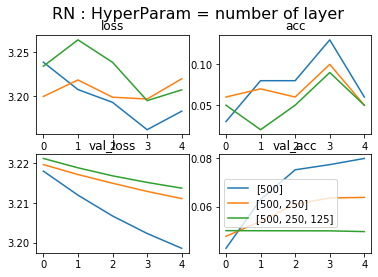

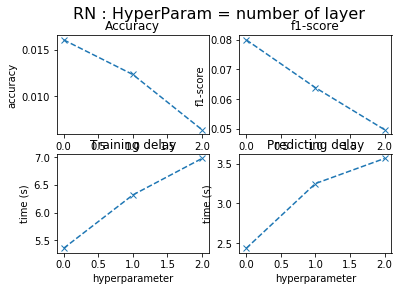

In [4]:
RN_plot_test()

In [5]:
perceptrons_number_test()

Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 2s 15ms/sample - loss: 3.2409 - acc: 0.0500 - val_loss: 3.2064 - val_acc: 0.0434
Epoch 2/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.2095 - acc: 0.0400 - val_loss: 3.2042 - val_acc: 0.0431
Epoch 3/5
100/100 [==============================] - 1s 5ms/sample - loss: 3.1956 - acc: 0.0800 - val_loss: 3.2021 - val_acc: 0.0414
Epoch 4/5
100/100 [==============================] - 0s 5ms/sample - loss: 3.2151 - acc: 0.0300 - val_loss: 3.1998 - val_acc: 0.0414
Epoch 5/5
100/100 [==============================] - 0s 5ms/sample - loss: 3.1971 - acc: 0.0500 - val_loss: 3.1976 - val_acc: 0.0421


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.04210409066859737 f1 : 0.01128672360410327
Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 2s 16ms/sample - loss: 3.2201 - acc: 0.0500 - val_loss: 3.2268 - val_acc: 0.0283
Epoch 2/5
100/100 [==============================] - 1s 5ms/sample - loss: 3.2172 - acc: 0.0300 - val_loss: 3.2239 - val_acc: 0.0369
Epoch 3/5
100/100 [==============================] - 1s 5ms/sample - loss: 3.2161 - acc: 0.0300 - val_loss: 3.2212 - val_acc: 0.0385
Epoch 4/5
100/100 [==============================] - 1s 5ms/sample - loss: 3.2070 - acc: 0.0400 - val_loss: 3.2186 - val_acc: 0.0376
Epoch 5/5
100/100 [==============================] - 1s 5ms/sample - loss: 3.2164 - acc: 0.0200 - val_loss: 3.2162 - val_acc: 0.0377


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.03767647795939963 f1 : 0.0077361335739454685
Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 2s 16ms/sample - loss: 3.2339 - acc: 0.0500 - val_loss: 3.2247 - val_acc: 0.0485
Epoch 2/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.2228 - acc: 0.0200 - val_loss: 3.2201 - val_acc: 0.0487
Epoch 3/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.2089 - acc: 0.0300 - val_loss: 3.2159 - val_acc: 0.0492
Epoch 4/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.1862 - acc: 0.0500 - val_loss: 3.2121 - val_acc: 0.0525
Epoch 5/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.1870 - acc: 0.0800 - val_loss: 3.2084 - val_acc: 0.0594
acc : 0.05939684219319986 f1 : 0.013003944945174201


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


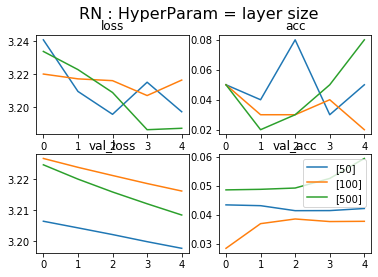

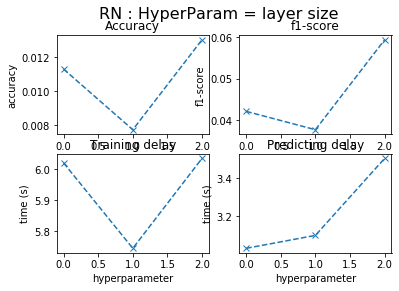

In [6]:
RN_plot_test()

In [7]:
learning_rate_test()

Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 1s 14ms/sample - loss: 3.2381 - acc: 0.0300 - val_loss: 3.2276 - val_acc: 0.0232
Epoch 2/5
100/100 [==============================] - 1s 7ms/sample - loss: 3.2253 - acc: 0.0300 - val_loss: 3.2274 - val_acc: 0.0232
Epoch 3/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.2220 - acc: 0.0300 - val_loss: 3.2273 - val_acc: 0.0232
Epoch 4/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.2162 - acc: 0.0300 - val_loss: 3.2272 - val_acc: 0.0232
Epoch 5/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.2241 - acc: 0.0200 - val_loss: 3.2271 - val_acc: 0.0232


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.023196235136866142 f1 : 0.0017799315216325163
Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 2s 15ms/sample - loss: 3.2275 - acc: 0.0500 - val_loss: 3.2320 - val_acc: 0.0589
Epoch 2/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.2105 - acc: 0.0600 - val_loss: 3.2271 - val_acc: 0.0652
Epoch 3/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.1952 - acc: 0.0600 - val_loss: 3.2222 - val_acc: 0.0659
Epoch 4/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.1981 - acc: 0.0700 - val_loss: 3.2176 - val_acc: 0.0659
Epoch 5/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.1812 - acc: 0.0400 - val_loss: 3.2134 - val_acc: 0.0661


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


acc : 0.06610787780902787 f1 : 0.008700033986709306
Train on 100 samples, validate on 35911 samples
Epoch 1/5
100/100 [==============================] - 2s 16ms/sample - loss: 3.2104 - acc: 0.0300 - val_loss: 3.2180 - val_acc: 0.0661
Epoch 2/5
100/100 [==============================] - 1s 7ms/sample - loss: 3.1095 - acc: 0.0900 - val_loss: 3.3254 - val_acc: 0.0883
Epoch 3/5
100/100 [==============================] - 1s 6ms/sample - loss: 3.0810 - acc: 0.0600 - val_loss: 3.2328 - val_acc: 0.0975
Epoch 4/5
100/100 [==============================] - 1s 6ms/sample - loss: 2.9752 - acc: 0.1400 - val_loss: 3.1977 - val_acc: 0.1023
Epoch 5/5
100/100 [==============================] - 1s 6ms/sample - loss: 2.9323 - acc: 0.1200 - val_loss: 3.1889 - val_acc: 0.0853
acc : 0.08532204616969731 f1 : 0.02684276358996219


C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


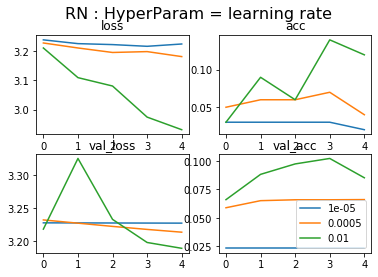

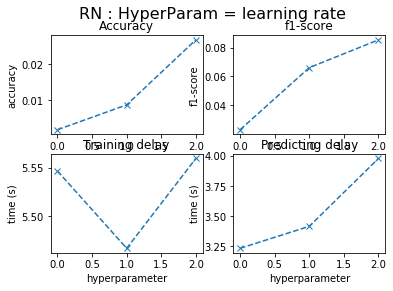

In [8]:
RN_plot_test()

In [9]:
epochs_number_test()

Train on 100 samples, validate on 35911 samples
Epoch 1/30
100/100 [==============================] - 2s 18ms/sample - loss: 3.2119 - acc: 0.0600 - val_loss: 3.2141 - val_acc: 0.0764
Epoch 2/30
100/100 [==============================] - 1s 6ms/sample - loss: 3.2012 - acc: 0.0700 - val_loss: 3.2094 - val_acc: 0.0710
Epoch 3/30
100/100 [==============================] - 1s 6ms/sample - loss: 3.1804 - acc: 0.0900 - val_loss: 3.2050 - val_acc: 0.0683
Epoch 4/30
100/100 [==============================] - 1s 6ms/sample - loss: 3.1793 - acc: 0.0700 - val_loss: 3.2011 - val_acc: 0.0674
Epoch 5/30
100/100 [==============================] - 1s 7ms/sample - loss: 3.1478 - acc: 0.0900 - val_loss: 3.1976 - val_acc: 0.0654
Epoch 6/30
100/100 [==============================] - 1s 7ms/sample - loss: 3.1522 - acc: 0.1400 - val_loss: 3.1945 - val_acc: 0.0642
Epoch 7/30
100/100 [==============================] - 1s 10ms/sample - loss: 3.1427 - acc: 0.1100 - val_loss: 3.1918 - val_acc: 0.0638
Epoch 8/30
1

KeyboardInterrupt: 

In [1]:
RN_plot_test()

NameError: name 'RN_plot_test' is not defined

### Discussion

## Question 5
### Présentation de la conception

faire diagramme

## Question 6
### Hyperparamètres des modèles choisis dans la conception


### Matrice des résultats

### Discussion

comparaison entre les modèles prit independemment et les modèles combinés

## Question 7 
### Formulation des recommandations

## Conclusion